In [181]:
#First out imports
#Lets import some stuff!

#Numpy
import numpy as np

#Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as feat


#Matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

#date tools
from datetime import datetime, timedelta
from netCDF4 import num2date

#os tools
import os

#pandas
import pandas as pd

from metpy.calc import get_wind_components
from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover, wx_code_map
from metpy.units import units
%matplotlib inline

In [182]:
metars_dir = '/Users/scollis/funded_projects/precip_change/data/highres/'
all_metars = os.listdir(metars_dir)

In [183]:
pandas_dict = {}
for metars in all_metars:
    if '.csv' in metars:
        print(metars[0:-4])
        this_panda = pd.read_csv(metars_dir + metars)
        this_panda['date'] = pd.to_datetime(this_panda['time'])
        this_panda.index = this_panda['date']
        pandas_dict.update({metars[0:-4]:this_panda})

KAAA
KASW
KAWG
KAZO
KBEH
KBIV
KBTL
KBUU
KC09
KC75
KCMY
KDEH
KDKB
KDLL
KDNV
KEFT
KEOK
KETB
KFEP
KFFL
KFKA
KFLD
KFSW
KFWA
KGBG
KGRR
KGSH
KGUS
KGYY
KHAI
KIGQ
KIIB
KIKK
KIRS
KJOT
KJVL
KLDM
KLNR
KLOT
KLSE
KLWA
KMIE
KMKG
KMPZ
KMQB
KMRJ
KMUT
KMWC
KMXO
KOEB
KOLZ
KOOA
KOSH
KPDC
KPNT
KRPJ
KRQB
KRST
KRYV
KSBM
KSBN
KSFY
KTIP
KUES
KUGN
KUNU
KVOK
KVPZ
KVTI
KVYS


In [184]:
def extract_time(pd_dict, dt, varss=None, debug=False):
    obs_table = {}
    stations = list(pd_dict.keys())
    if varss is None:
        varss = list(pd_dict[stations[0]].keys())
    for var in varss:
        obs_table.update({var : np.array([])})
    for station in stations:
        try:
            if debug:
                print(station)
            idx = pd_dict[station].index.get_loc(dt, method='nearest')
            s = pd_dict[station].iloc[idx]
            for p in varss:
                obs_table[p] = np.append(obs_table[p], s[p])
        except:# pd.errors.InvalidIndexError:
            print(station, "something went wrong")
    return varss, obs_table

        
    


In [191]:
my_time = datetime(2017, 12, 5, 0,55)
meas, at_time = extract_time(pandas_dict, my_time)


KAZO something went wrong
KFWA something went wrong
KGRR something went wrong
KGUS something went wrong
KMIE something went wrong
KMKG something went wrong
KSBN something went wrong
KUES something went wrong
KUGN something went wrong
KVOK something went wrong


In [215]:
def region_plot(obs_panel, wind_units = None):
    
    if wind_units is None:
        wind_units = 'knots'
    proj = ccrs.PlateCarree()

    # Use the cartopy map projection to transform station locations to the map and
    # then refine the number of stations plotted by setting a 300km radius
    point_locs = proj.transform_points(ccrs.PlateCarree(), obs_panel['lon'], obs_panel['lat'])
    u, v = get_wind_components((obs_panel['wind_speed'] * units('m/s')).to('knots'),
                               obs_panel['wind_from_direction'] * units.degree)

    # Convert the fraction value into a code of 0-8 and compensate for NaN values,
    # which can be used to pull out the appropriate symbol
    cloud_frac = (8 * obs_panel['cloud_area_fraction'])
    cloud_frac[np.isnan(cloud_frac)] = 10
    cloud_frac = cloud_frac.astype(int)

    # Map weather strings to WMO codes, which we can use to convert to symbols
    # Only use the first symbol if there are multiple
    wx_codes = obs_panel['weather']
    bad_juju = wx_codes == ''
    wx_codes[bad_juju] = ''
    wx = [wx_code_map[s[2:-1].split()[0] if ' ' in s else s[2:-1]] for s in wx_codes]
    fig = plt.figure(figsize=(20, 10))
    #add_metpy_logo(fig, 1000, 50, size='small')
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Set up a cartopy feature for state borders.
    state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='110m', facecolor='none')

    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(feat.LAND, zorder=-1)
    ax.add_feature(feat.OCEAN, zorder=-1)
    ax.add_feature(feat.LAKES, zorder=-1)
    ax.coastlines(resolution='110m', zorder=2, color='black')
    ax.add_feature(state_boundaries, edgecolor='black')
    ax.add_feature(feat.BORDERS, linewidth=2, edgecolor='black')

    # Set plot bounds
    ax.set_extent((-118, -73, 23, 50))

    #
    # Here's the actual station plot
    #

    # Start the station plot by specifying the axes to draw on, as well as the
    # lon/lat of the stations (with transform). We also the fontsize to 12 pt.
    stationplot = StationPlot(ax, obs_panel['lon'], obs_panel['lat'], clip_on=True,
                              transform=ccrs.PlateCarree(), fontsize=12)

    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    stationplot.plot_parameter('NW', obs_panel['air_temperature'], color='red')
    stationplot.plot_parameter('SW', obs_panel['dew_point_temperature'],
                               color='darkgreen')

    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    #stationplot.plot_parameter('NE', obs_panel['slp'], formatter=lambda v: format(10 * v, '.0f')[-3:])

    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    stationplot.plot_symbol('C', cloud_frac, sky_cover)

    # Same this time, but plot current weather to the left of center, using the
    # `current_weather` mapper to convert symbols to the right glyphs.
    stationplot.plot_symbol('W', wx, current_weather)

    # Add wind barbs
    stationplot.plot_barb(u, v)

    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), obs_panel['station'])

    bbox = [obs_panel['lon'].min(), obs_panel['lon'].max(), obs_panel['lat'].min(),obs_panel['lat'].max()]
    tk = 1.
    ax.set_xticks(np.arange(bbox[0], bbox[1], tk), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(bbox[2], bbox[3], tk), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True, number_format='.1f')
    lat_formatter = LatitudeFormatter(number_format='.1f')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent(bbox)
    tt = 'Observations at ' + obs_panel['time'][0] + ' UTC'
    
    plt.title(tt)
    
    #plt.show()
    plt.savefig('/Users/scollis/funded_projects/precip_change/images/vectors.png')

KAZO something went wrong
KFWA something went wrong
KGRR something went wrong
KGUS something went wrong
KMIE something went wrong
KMKG something went wrong
KSBN something went wrong
KUES something went wrong
KUGN something went wrong
KVOK something went wrong


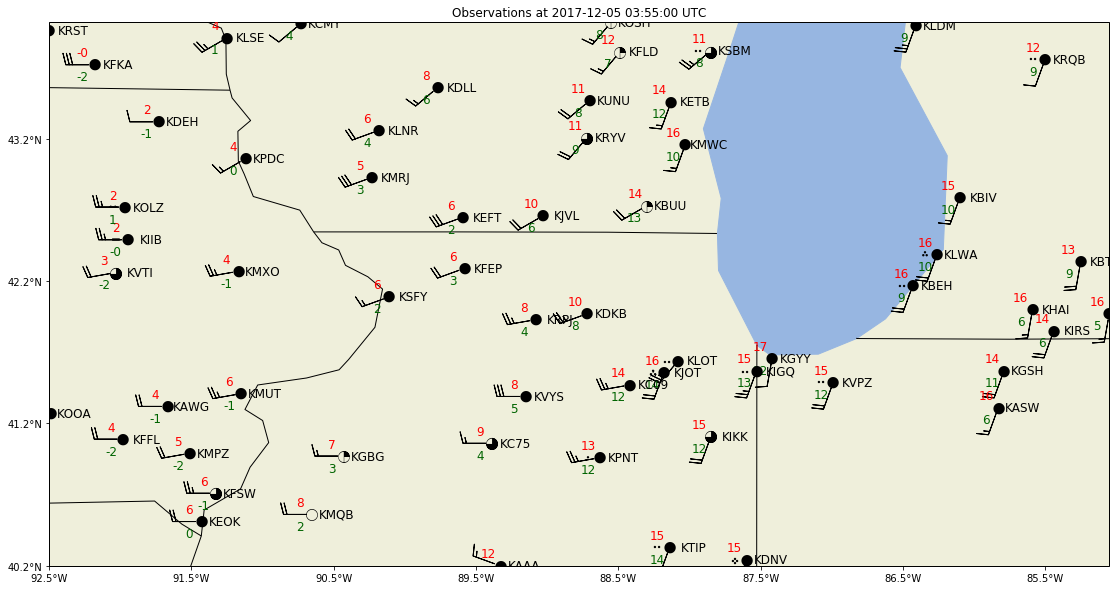

In [216]:
my_time = datetime(2017, 12, 5, 4)
meas, at_time = extract_time(pandas_dict, my_time)
region_plot(at_time, wind_units='km/h')

In [197]:
tt = my_time.strftime('%Y-%m-%d %H:%M')
tt

'2017-12-05 10:55'

In [203]:
at_time['time'][0]

'2017-12-05 10:55:00'